# Comparing Models

This notebook chooses the most appropriate prompt and prompt structure for the OCR correction. 

In [80]:
#import config  # Import your config.py file this contains you openai api key
import pandas as pd
import numpy as np
import os
from llm_comparison_toolkit import RateLimiter, get_response_openai, get_response_anthropic, get_response_replicate, create_config_dict_func, compare_request_configurations, generate_model_configs
from evaluate import load
from evaluation_funcs import evaluate_correction_performance, evaluate_correction_performance_folders, get_metric_error_reduction
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import files_to_df_func, files_to_df_core_func
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import re


from dotenv import load_dotenv, find_dotenv
load_dotenv()
save_appendix = os.getenv("save_appendix")


dev_data_folder = 'data/dev_data'
dev_transcripts = os.path.join(dev_data_folder, 'dev_data_transcript')
dev_raw_ocr_folder =  os.path.join(dev_data_folder,'dev_raw_ocr' )
dev_system_message_folder = os.path.join(dev_data_folder,'dev_system_message_variants' )


#NCSE

ncse_folder = 'data/transcription_returned_ocr'
ncse_articles_raw = os.path.join(ncse_folder, 'transcription_raw_ocr')
ncse_articles_transcribed = os.path.join(ncse_folder, 'transcription_files') 
ncse_articles_results = os.path.join(ncse_folder, 'corrected_folder')

#Overproof
overproof_folder = 'data/overproof'

smh_folder =  os.path.join(overproof_folder, 'SMH')
smh_articles_raw = os.path.join(smh_folder, 'article_level', 'raw')
smh_articles_transcribed = os.path.join(smh_folder, 'article_level', 'corrected') #in the dataset they are reffered to as corrected but this clashes with my naming convention
smh_articles_results = os.path.join(smh_folder, 'results')

ca_folder =  os.path.join(overproof_folder, 'CA')
ca_articles_raw = os.path.join(ca_folder, 'article_level', 'raw')
ca_articles_transcribed = os.path.join(ca_folder, 'article_level', 'corrected') #in the dataset they are reffered to as corrected but this clashes with my naming convention
ca_articles_results = os.path.join(ca_folder, 'results')

#load the dev and test sets for prompt development and selection
dev_data_df = pd.read_csv(os.path.join(dev_data_folder,'dev_data_raw.csv'))


#for saving data to be used in the analysis
if not os.path.exists('data/analysis'):
    os.makedirs('data/analysis')


wer = load("wer")
cer = load("cer")


model_name_code = pd.Series(
    {'Llama 2 70B':'llama2-70b-4096',
 'Gemma 7B':'gemma-7b-it',
 'Claude 3 Opus':'claude-3-opus-20240229',
 'Claude 3 Haiku':'claude-3-haiku-20240307',
 'GPT-4':'gpt-4-turbo-preview',
 'GPT-3.5':'gpt-3.5-turbo',
 'Mixtral 8x7B':'mixtral-8x7b-32768',
 "Llama 3":'meta-llama-3-70b-instruct',
 "Llama 3 base":'meta/meta-llama-3-70b',
 'Overproof':'overproof'})


eval_metric = 'CER'

## Evaluate system prompt tests

We evaluate the system prompts below to see if thre is any significant difference between the prompts


# Evaluating models on the test set

Having identified two different prompts and that the prompts appear to work better when places after the text we can now compare the different models


The below code creates the basic configuration dictionaries for each model and then fills in the with the two different prompt messages creating a single list of all basic prompt/model configurations. It then calls all the LLM's and saves the results.
This works in series so takes a while.

## Create API configurations

In [2]:
#Create the prompt/system message using the best performing from the previous section

full_prompt = "{content_html}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. The text is from an english newspaper in the 1800's. The text may be an advert or article and may be missing the beggining or end. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""

instruct_prompt = "{content_html}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""

boros_basic  = "{content_html}"+f""" \n \n """ +"Correct the text"

boros_complex  ="{content_html}"+f""" \n \n """ + f"""Please assist with reviewing and correcting errors in texts produced by automatic transcription (OCR) of historical documents.
Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. 
Do not write anything else than the corrected text."""

In [3]:
groq_alt_endpoint = {'alt_endpoint':{'base_url':'https://api.groq.com/openai/v1',
                     'api_key':os.getenv("GROQ_API_KEY")}}

basic_model_configs = pd.DataFrame({
    'get_response_func': [get_response_openai, get_response_openai, get_response_anthropic, get_response_anthropic, 
                          get_response_openai,# get_response_openai, 
                          get_response_openai, get_response_replicate,# get_response_replicate, 
                          get_response_replicate], 
    'engine': ['gpt-3.5-turbo', 'gpt-4-turbo-preview', "claude-3-haiku-20240307", "claude-3-opus-20240229", 
               'mixtral-8x7b-32768',#'llama2-70b-4096', 
               'gemma-7b-it', 'meta/meta-llama-3-70b-instruct', 'meta/meta-llama-3-70b',
                # 'meta/llama-2-70b'
                 ],
    'rate_limit':[160e3, 80e3, 100e3, 40e3, 9e3, #15e3,
                   15e3, 100e3,# 100e3,
                     100e3],
    'additional_args': [
        {}, {}, {}, {}, 
        groq_alt_endpoint, 
        #groq_alt_endpoint, 
        groq_alt_endpoint,
        {}, {}#,{}
    ]
})

full_model_configs = generate_model_configs(basic_model_configs, full_prompt, 'full')
instruct_model_configs = generate_model_configs(basic_model_configs, instruct_prompt, 'instruct')

#I think on reflection I only need to compare boros complex on gpt-4 as this was the best performer in their paper
boros_configs_ncse = [
    (get_response_openai, 'gpt-4-turbo-preview', boros_complex, "boros_complex_"),
]

boros_list = [
    create_config_dict_func(
        get_response_func=config[0],
        rate_limiter=RateLimiter(80e3),
        engine=config[1],
        system_message_template="",
        prompt_template=config[2],
        additional_args={"response_name": config[3]}
    )
    for config in boros_configs_ncse
]

model_configs = full_model_configs + instruct_model_configs + boros_list



## Perform all API calls

The below section is what actually calls the API, the code points to the folders where the raw OCR is and provides a path to where the corrected text should be stored.

### NCSE

In [4]:
corrected_folder = ncse_articles_results
#
# This naming business needs to be cleaned up so the actual article ID is used. until then just have the following mess
#
# 

test_data_new = pd.read_csv(os.path.join(dev_data_folder,'transcription_raw_ocr.csv'))
test_data_new = test_data_new.loc[test_data_new ['file_name'].isin(files_to_df_func(ncse_articles_transcribed )['file_name'])] #subset to just the data I have transcribed

#This goes through the list of articles that have been transcribed, checks to see if there is a corrected version and if not generates it
compare_request_configurations(test_data_new, model_configs, folder_path=corrected_folder)

### Boros etal re-evaluation

The post-OCR correction worked so well that the Boros etal prompt is being re-evaluated

In [5]:
boros_complex  ="{content}"+f""" \n \n """ + f"""Please assist with reviewing and correcting errors in texts produced by automatic transcription (OCR) of historical documents.
Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. 
Do not write anything else than the corrected text."""


boros_config = generate_model_configs(basic_model_configs.iloc[0:2, :], boros_complex, 'boros_complex')[1]

### Sydney Morning Herald

This section performs the correction test on dataset 2 of the Overproof collection. This is data from the Sydney Morning Herald. In addition it re-tests the Boros et al.

In [6]:
smh_data = files_to_df_core_func(smh_articles_raw )

smh_data['content'] = smh_data['content'].str.replace('\n', ' ')

smh_data['id'] = smh_data['file_name'] # this is needed as the processing log uses an id to keep track of what has been processed and what hasn't to allow for easy restarts

full_prompt_smh = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. The text is from The Sydney Morning Herald 1842 -1950. The text may be an advert or article and may be missing the beggining or end. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""

instruct_prompt_smh = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""

full_model_configs_smh = generate_model_configs(basic_model_configs, full_prompt_smh, 'full')
instruct_model_configs_smh = generate_model_configs(basic_model_configs, instruct_prompt_smh, 'instruct')

#Boros et al prompt added in as the overall system works so well, it seems strange theirs didn't work, this is a quick check
smh_configs = full_model_configs_smh + instruct_model_configs_smh  + [boros_config ]

corrected_folder_smh = smh_articles_results

compare_request_configurations(smh_data, smh_configs, folder_path=corrected_folder_smh)

### Chronicalling America

This section performs the correction test on dataset 2 of the Overproof collection. This is data from the Chronicalling America Dataset. 

In [7]:
ca_data = files_to_df_core_func(ca_articles_raw )

ca_data['content'] = ca_data['content'].str.replace('\n', ' ')

ca_data['id'] = ca_data['file_name'] # this is needed as the processing log uses an id to keep track of what has been processed and what hasn't to allow for easy restarts

full_prompt_ca = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. The text is from American Newspapers 1870 -1922. The text may be an advert or article and may be missing the beggining or end. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""

instruct_prompt_ca = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""


full_model_configs_ca = generate_model_configs(basic_model_configs, full_prompt_ca, 'full')
instruct_model_configs_ca = generate_model_configs(basic_model_configs, instruct_prompt_ca, 'instruct')

ca_configs = full_model_configs_ca + instruct_model_configs_ca  + [boros_config ]

corrected_folder_ca = ca_articles_results

compare_request_configurations(ca_data, ca_configs, folder_path=corrected_folder_ca)

## Evaluate the prompts across all models

On the smaller models, Full is worse than instruct on the larger models the reverse. Maybe this is related to ability to 'focus' or hold isntructions in memory?

In [8]:
##
## double check get_metric_error_reduction
##

corrected_folder = ncse_articles_results 

gt_folder = ncse_articles_transcribed 

raw_ocr = ncse_articles_raw

ncse_performance_eval =  evaluate_correction_performance_folders(corrected_folder, gt_folder, wer, cer)

ncse_raw_ocr_eval =  evaluate_correction_performance(raw_ocr, gt_folder , wer, cer, 'raw_ocr')


ncse_error_reduction = get_metric_error_reduction(ncse_performance_eval, ncse_raw_ocr_eval )

ncse_error_reduction.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%'))

,WER,CER,lev_dist
,50%,50%,50%
type,,,
instruct__meta-llama-3-70b,-102.41,-587.99,-592.88
full__meta-llama-3-70b,-102.68,-481.02,-468.17
full__llama2-70b-4096,56.83,-28.27,-27.33
instruct__llama2-70b-4096,53.24,-11.20,-12.44
full__gemma-7b-it,20.47,-2.34,-2.55
instruct__gemma-7b-it,20.35,0.15,0.12
full__mixtral-8x7b-32768,48.72,6.60,5.74
instruct__mixtral-8x7b-32768,48.48,7.01,6.69


In [9]:
print(ncse_raw_ocr_eval.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%')))
ncse_performance_eval.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%'))

          WER   CER lev_dist
          50%   50%      50%
type                        
raw_ocr  0.63  0.17    341.0


,WER,CER,lev_dist
,50%,50%,50%
type,,,
instruct__claude-3-opus-20240229,0.15,0.06,115.0
full__claude-3-opus-20240229,0.15,0.07,113.0
boros_complex__gpt-4-turbo-preview,0.17,0.09,127.0
full__gpt-4-turbo-preview,0.17,0.09,114.0
instruct__gpt-4-turbo-preview,0.17,0.10,126.0
instruct__gpt-3.5-turbo,0.28,0.13,172.0
full__llama2-70b-4096,0.21,0.14,317.0
instruct__llama2-70b-4096,0.22,0.15,259.5


In [10]:
corrected_folder = smh_articles_results 

gt_folder = smh_articles_transcribed 

raw_ocr = smh_articles_raw

smh_performance_eval =  evaluate_correction_performance_folders(corrected_folder, gt_folder, wer, cer)

smh_raw_ocr_eval =  evaluate_correction_performance(raw_ocr, gt_folder , wer, cer, 'raw_ocr')

smh_error_reduction = get_metric_error_reduction(smh_performance_eval, smh_raw_ocr_eval )

smh_error_reduction.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%'))

,WER,CER,lev_dist
,50%,50%,50%
type,,,
full__llama-2-70b,-89.25,-963.01,-914.86
instruct__llama-2-70b,-89.50,-958.60,-895.77
instruct__meta-llama-3-70b,-88.52,-867.47,-865.27
full__meta-llama-3-70b,-90.56,-864.63,-853.01
full__gemma-7b-it,3.26,-35.65,-35.34
instruct__mixtral-8x7b-32768,17.39,-19.11,-20.00
full__mixtral-8x7b-32768,18.00,-14.63,-15.24
instruct__gemma-7b-it,9.66,-12.93,-13.04


In [11]:
print(smh_raw_ocr_eval.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%')))

smh_performance_eval.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%'))

          WER   CER lev_dist
          50%   50%      50%
type                        
raw_ocr  0.51  0.08    131.0


,WER,CER,lev_dist
,50%,50%,50%
type,,,
boros_complex__gpt-4-turbo-preview,0.34,0.04,65.0
full__claude-3-haiku-20240307,0.37,0.04,73.0
full__claude-3-opus-20240229,0.34,0.04,69.0
full__gpt-3.5-turbo,0.35,0.04,87.0
instruct__gpt-3.5-turbo,0.35,0.04,78.0
instruct__claude-3-opus-20240229,0.34,0.04,71.0
instruct__gpt-4-turbo-preview,0.34,0.05,75.0
instruct__claude-3-haiku-20240307,0.36,0.05,81.0


In [12]:
corrected_folder = ca_articles_results 

gt_folder = ca_articles_transcribed 

raw_ocr = ca_articles_raw

ca_performance_eval =  evaluate_correction_performance_folders(corrected_folder, gt_folder, wer, cer)

ca_raw_ocr_eval =  evaluate_correction_performance(raw_ocr, gt_folder , wer, cer, 'raw_ocr')

ca_error_reduction = get_metric_error_reduction(ca_performance_eval, ca_raw_ocr_eval )

ca_error_reduction.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%'))

,WER,CER,lev_dist
,50%,50%,50%
type,,,
full__llama-2-70b,-59.57,-784.90,-761.72
instruct__llama-2-70b,-61.06,-752.31,-741.10
full__meta-llama-3-70b,-71.75,-741.39,-739.31
instruct__meta-llama-3-70b,-63.14,-729.38,-725.21
instruct__gemma-7b-it,5.66,-41.00,-42.38
full__gemma-7b-it,3.04,-38.01,-38.15
instruct__mixtral-8x7b-32768,13.72,-22.07,-22.36
full__mixtral-8x7b-32768,15.72,-16.30,-14.86


In [13]:
print(ca_raw_ocr_eval.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%')))

ca_performance_eval.groupby('type').describe().filter(regex = '50|median').round(2).sort_values((eval_metric, '50%'))

          WER  CER lev_dist
          50%  50%      50%
type                       
raw_ocr  0.62  0.1    198.0


,WER,CER,lev_dist
,50%,50%,50%
type,,,
boros_complex__gpt-4-turbo-preview,0.45,0.05,107.0
full__claude-3-opus-20240229,0.43,0.05,117.0
instruct__gpt-3.5-turbo,0.45,0.05,100.5
instruct__claude-3-opus-20240229,0.44,0.05,119.0
instruct__gpt-4-turbo-preview,0.45,0.06,118.0
full__gpt-3.5-turbo,0.46,0.06,108.0
full__gpt-4-turbo-preview,0.45,0.06,120.5
instruct__claude-3-haiku-20240307,0.47,0.06,112.0


In [45]:
ncse_median = ncse_error_reduction.groupby('type')[eval_metric].median().round(1)
smh_median = smh_error_reduction.groupby('type')[eval_metric].median().round(1)
ca_median = ca_error_reduction.groupby('type')[eval_metric].median().round(1)

# Combine the results into a new dataframe
result_df = pd.DataFrame({
    'NCSE': ncse_median,
    'SMH': smh_median,
    'CA': ca_median
})

# Reset the index to make 'type' a regular column
result_df = result_df.reset_index()

result_df = result_df.loc[~result_df['type'].isin(['boros_basic__gpt-4-turbo-preview',  'claude_temp_claude-3-opus-20240229'])]

result_df['model'] = result_df['type'].str.split('_').str[-1]
result_df['prompt'] = result_df['type'].str.split('_').str[0]

result_df = result_df.sort_values('NCSE').merge(model_name_code.reset_index().rename(columns={0: 'model'}), on='model').rename(columns={'index': 'Model'})

result_df['Model'] = np.where(result_df['prompt']=='boros', result_df['Model'] + " Boros", result_df['Model'])

#result_df = result_df.loc[~(result_df['Model'].str.contains('Llama 2'))]

result_df[['Model', 'prompt', 'NCSE', 'SMH', 'CA']].sort_values(['NCSE'])

,Model,prompt,NCSE,SMH,CA
0,Llama 2 70B,full,-28.3,5.8,-4.9
1,Llama 2 70B,instruct,-11.2,6.5,-6.5
2,Gemma 7B,full,-2.3,-35.7,-38.0
3,Gemma 7B,instruct,0.1,-12.9,-41.0
4,Mixtral 8x7B,full,6.6,-14.6,-16.3
5,Mixtral 8x7B,instruct,7.0,-19.1,-22.1
6,Claude 3 Haiku,full,14.0,38.4,26.0
7,Llama 3,instruct,16.1,17.9,14.2
8,Llama 3,full,19.1,12.9,-9.4
9,Claude 3 Haiku,instruct,27.8,35.7,34.7


In [46]:
def render_latex_with_formatting(df, caption, label):

    df = df.copy()
    # Format the 'Total' row by appending \textbf{} to each element
    #df.iloc[-1] = df.iloc[-1].apply(lambda x: '\\textbf{' + str(x) + '}')
    
    # Convert DataFrame to LaTeX
    latex_table = df.to_latex(
        index=False,
        float_format="%.2f" ,
        escape=False,  # Important to render LaTeX commands within the table properly
        column_format='p{5cm}cccc',  # One left-aligned column followed by four centered columns
        bold_rows=True,  # Bold the headers
        caption=caption,
        label=label
    )
    return latex_table


In [47]:
results_tab = result_df.loc[(result_df['prompt']!='instruct') & ~(result_df['Model'].str.contains('Llama 2')), ['Model',  'NCSE', 'SMH', 'CA']].sort_values(['Model'])

results_tab = render_latex_with_formatting(results_tab,   
                            'Model performance across the datasets measured in Error Reduction Percentage, higher is better.There is significant variation in how well the LMs are able to perform post-OCR correction, and significant differences between prompts for certain models.',
                            'tab:results'  )

print(results_tab)

\begin{table}
\caption{Model performance across the datasets measured in Error Reduction Percentage, higher is better.There is significant variation in how well the LMs are able to perform post-OCR correction, and significant differences between prompts for certain models.}
\label{tab:results}
\begin{tabular}{p{5cm}cccc}
\toprule
Model & NCSE & SMH & CA \\
\midrule
Claude 3 Haiku & 14.00 & 38.40 & 26.00 \\
Claude 3 Opus & 64.10 & 51.00 & 48.20 \\
GPT-3.5 & 37.70 & 39.20 & 44.20 \\
GPT-4 & 60.40 & 42.10 & 38.20 \\
GPT-4 Boros & 61.70 & 48.40 & 45.60 \\
Gemma 7B & -2.30 & -35.70 & -38.00 \\
Llama 3 & 19.10 & 12.90 & -9.40 \\
Mixtral 8x7B & 6.60 & -14.60 & -16.30 \\
Overproof & NaN & 28.40 & 34.60 \\
\bottomrule
\end{tabular}
\end{table}



In [48]:
results_tab = render_latex_with_formatting(result_df.loc[result_df['prompt']=='instruct', ['Model',  'NCSE', 'SMH', 'CA']].sort_values(['Model']), 
                             'Model performance across the datasets measured in Error Reduction Percentage, higher is better.There is significant variation in how well the LMs are able to perform post-OCR correction, and significant differences between prompts for certain models.',
                             'tab:results')

print(results_tab)

\begin{table}
\caption{Model performance across the datasets measured in Error Reduction Percentage, higher is better.There is significant variation in how well the LMs are able to perform post-OCR correction, and significant differences between prompts for certain models.}
\label{tab:results}
\begin{tabular}{p{5cm}cccc}
\toprule
Model & NCSE & SMH & CA \\
\midrule
Claude 3 Haiku & 27.80 & 35.70 & 34.70 \\
Claude 3 Opus & 62.70 & 45.50 & 47.00 \\
GPT-3.5 & 39.40 & 42.90 & 44.10 \\
GPT-4 & 59.80 & 41.80 & 37.60 \\
Gemma 7B & 0.10 & -12.90 & -41.00 \\
Llama 2 70B & -11.20 & 6.50 & -6.50 \\
Llama 3 & 16.10 & 17.90 & 14.20 \\
Mixtral 8x7B & 7.00 & -19.10 & -22.10 \\
\bottomrule
\end{tabular}
\end{table}



In [84]:
result_df.loc[result_df['prompt']=='instruct', ['Model',  'NCSE', 'SMH', 'CA']].sort_values(['Model'])

,Model,NCSE,SMH,CA
9,Claude 3 Haiku,27.8,35.7,34.7
15,Claude 3 Opus,62.7,45.5,47.0
11,GPT-3.5,39.4,42.9,44.1
12,GPT-4,59.8,41.8,37.6
3,Gemma 7B,0.1,-12.9,-41.0
1,Llama 2 70B,-11.2,6.5,-6.5
7,Llama 3,16.1,17.9,14.2
5,Mixtral 8x7B,7.0,-19.1,-22.1


In [60]:
df_melted = result_df.melt(id_vars=['model', 'prompt'], value_vars=['NCSE', 'SMH', 'CA'], 
                    var_name='Dataset', value_name='Value')

df_full = result_df[result_df['prompt'] == 'full']
df_instruct = result_df[result_df['prompt'] == 'instruct']

# Melt the filtered DataFrames
df_full_melted = df_full.melt(id_vars=['model'], value_vars=['NCSE', 'SMH', 'CA'], var_name='Dataset', value_name='Value_Full')
df_instruct_melted = df_instruct.melt(id_vars=['model'], value_vars=['NCSE', 'SMH', 'CA'], var_name='Dataset', value_name='Value_Instruct')

df_merged = pd.merge(df_full_melted, df_instruct_melted, on=['model', 'Dataset'])

# Calculate the difference
df_merged['Difference'] = df_merged['Value_Full'] - df_merged['Value_Instruct']

df_merged = df_merged.loc[~(df_merged['model'].str.contains('llama2')),:].merge(model_name_code.reset_index().rename(columns={0: 'model'}), on='model').rename(columns={'index': 'Model'})


In [79]:
diff_df = df_merged.loc[:, ['Model', 'Dataset' ,'Value_Full', 'Value_Instruct', 'Difference']].sort_values('Model')

print(render_latex_with_formatting(diff_df, caption = 'The difference between the two prompts across all models and datasets', label= 'tab:prompt_diff'))

\begin{table}
\caption{The differnce between the two prompts across all models and datasets}
\label{tab:prompt_diff}
\begin{tabular}{p{5cm}cccc}
\toprule
Model & Dataset & Value_Full & Value_Instruct & Difference \\
\midrule
Claude 3 Haiku & NCSE & 14.00 & 27.80 & -13.80 \\
Claude 3 Haiku & CA & 26.00 & 34.70 & -8.70 \\
Claude 3 Haiku & SMH & 38.40 & 35.70 & 2.70 \\
Claude 3 Opus & CA & 48.20 & 47.00 & 1.20 \\
Claude 3 Opus & NCSE & 64.10 & 62.70 & 1.40 \\
Claude 3 Opus & SMH & 51.00 & 45.50 & 5.50 \\
GPT-3.5 & CA & 44.20 & 44.10 & 0.10 \\
GPT-3.5 & NCSE & 37.70 & 39.40 & -1.70 \\
GPT-3.5 & SMH & 39.20 & 42.90 & -3.70 \\
GPT-4 & NCSE & 60.40 & 59.80 & 0.60 \\
GPT-4 & CA & 38.20 & 37.60 & 0.60 \\
GPT-4 & SMH & 42.10 & 41.80 & 0.30 \\
Gemma 7B & CA & -38.00 & -41.00 & 3.00 \\
Gemma 7B & NCSE & -2.30 & 0.10 & -2.40 \\
Gemma 7B & SMH & -35.70 & -12.90 & -22.80 \\
Llama 3 & NCSE & 19.10 & 16.10 & 3.00 \\
Llama 3 & CA & -9.40 & 14.20 & -23.60 \\
Llama 3 & SMH & 12.90 & 17.90 & -5.00 \\
Mixtr

In [82]:
diff_df.sort_values('Value_Full')

,Model,Dataset,Value_Full,Value_Instruct,Difference
2,Claude 3 Haiku,NCSE,14.0,27.8,-13.8
16,Claude 3 Haiku,CA,26.0,34.7,-8.7
9,Claude 3 Haiku,SMH,38.4,35.7,2.7
20,Claude 3 Opus,CA,48.2,47.0,1.2
6,Claude 3 Opus,NCSE,64.1,62.7,1.4
13,Claude 3 Opus,SMH,51.0,45.5,5.5
18,GPT-3.5,CA,44.2,44.1,0.1
4,GPT-3.5,NCSE,37.7,39.4,-1.7
11,GPT-3.5,SMH,39.2,42.9,-3.7
5,GPT-4,NCSE,60.4,59.8,0.6


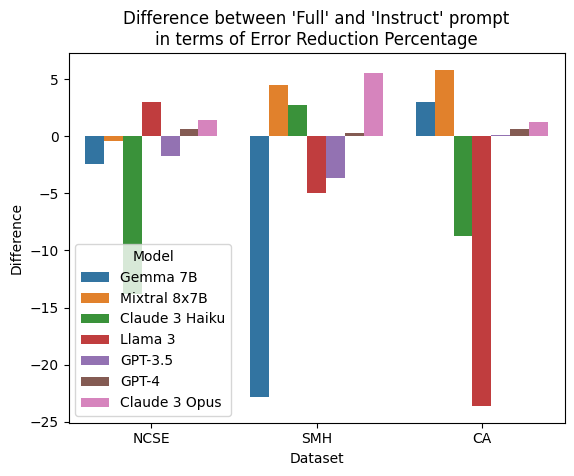

In [85]:
sns.barplot(data = df_merged, x = 'Dataset', y = 'Difference', hue = 'Model')
plt.title("Difference between 'Full' and 'Instruct' prompt\nin terms of Error Reduction Percentage")

plt.savefig(os.path.join(save_appendix,"prompt_comparison.pdf"))